## Removing Stray Magnetic Fields from the KPLO Magnetometer Measurements

In [2]:
"Import Necessary Libraries"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fcwt

#### July 5th to 7th, 2023

In [3]:
"Load KMAG Data"
kmag1 = pd.read_csv(r'c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\utility\SPACE_DATA\KPLO\KPLO_KMAG_230705_GSE_1sec.csv')
kmag2 = pd.read_csv(r'c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\utility\SPACE_DATA\KPLO\KPLO_KMAG_230706_GSE_1sec.csv')
kmag3 = pd.read_csv(r'c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\utility\SPACE_DATA\KPLO\KPLO_KMAG_230707_GSE_1sec.csv')
kmag = pd.concat([kmag1, kmag2, kmag3])

"Load THEMIS Data"
themis1 = pd.read_csv(r'c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\utility\SPACE_DATA\THEMIS\20230705_themis_thb_fgm_fgs_l2.csv')
themis2 = pd.read_csv(r'c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\utility\SPACE_DATA\THEMIS\20230706_themis_thb_fgm_fgs_l2.csv')
themis3 = pd.read_csv(r'c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\utility\SPACE_DATA\THEMIS\20230707_themis_thb_fgm_fgs_l2.csv')
themis = pd.concat([themis1, themis2, themis3])

"Convert THEMIS Data to Numpy Arrays"
Bx_th = themis['bx_gse'].to_numpy(); By_th = themis['by_gse'].to_numpy(); Bz_th = themis['bz_gse'].to_numpy()
B_th = np.array([Bx_th, By_th, Bz_th])

"Convert KPLO Data to Numpy Arrays"
B1_x = kmag['MAG1-X'].to_numpy(); B1_y = kmag['MAG1-Y'].to_numpy(); B1_z = kmag['MAG1-Z'].to_numpy()
B2_x = kmag['MAG2-X'].to_numpy(); B2_y = kmag['MAG2-Y'].to_numpy(); B2_z = kmag['MAG2-Z'].to_numpy()
B3_x = kmag['MAG3-X'].to_numpy(); B3_y = kmag['MAG3-Y'].to_numpy(); B3_z = kmag['MAG3-Z'].to_numpy()
B_3b = np.vstack((B3_x, B3_y, B3_z)); B_3b = np.nan_to_num(B_3b)
B_2b = np.vstack((B2_x, B2_y, B2_z)); B_2b = np.nan_to_num(B_2b)
B_1b = np.vstack((B1_x, B1_y, B1_z)); B_1b = np.nan_to_num(B_1b)
B_kplo = np.array([B_1b, B_2b, B_3b])

"Extract Timestamps"
themis_t = pd.to_datetime(themis['UTC']).to_numpy()
kplo_t = pd.to_datetime(kmag['UTC']).to_numpy()

In [3]:
"Calculate Coupling Coefficients"
from magprime.utility import calculate_coupling_coefficients


"Algorithm Parameters"
aii = calculate_coupling_coefficients(B_kplo, fs = 1, sspTol=20)

c:\Users\alexp\anaconda3\lib\site-packages\pymssa\mssa.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
aii = np.array([ 7.01002316, 75.24653706,  6.26681301])
print(aii)


[ 7.01002316 75.24653706  6.26681301]


In [5]:
"Apply WAIC-UP"
from magprime.algorithms import WAICUP


"Note: WAIC-UP is not designed to work with low-frequency data due to the Cone of Influence (COI). Detrending is necessary to avoid low-frequency artefacts."
WAICUP.fs = 1 # Sampling Frequency
WAICUP.detrend = True # Detrend the data
WAICUP.uf = 8640*4 # Number of points in uniform filter (uf)
WAICUP.aii = aii # Coupling Coefficients

"Clean the data"
B_WAICUP = WAICUP.clean(np.copy(B_kplo), triaxial=True)


c:\Users\alexp\anaconda3\lib\site-packages\magprime\algorithms\WAICUP.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  waicup_level1[i] = dual(np.vstack((sig[pairs[i][0]], sig[pairs[i][1]])), dt, dj)
c:\Users\alexp\anaconda3\lib\site-packages\magprime\algorithms\WAICUP.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  result[axis] = cleanWAICUP(B[:,axis,:])


KeyboardInterrupt: 

In [1]:
"""Plot Noise and Cleaned Data"""
fig, axs = plt.subplots(3, 2, figsize=(20, 8), sharex=True, sharey=True)

# Plotting
start = 25*3600; end = 45*3600
axs[0,0].plot(kplo_t[start:end], B_kplo[0,2,start:end], label=f"MAG1")
axs[1,0].plot(kplo_t[start:end], B_kplo[1,2,start:end], label=f"MAG1")
axs[2,0].plot(kplo_t[start:end], B_kplo[2,2,start:end], label=f"MAG1")
axs[0,1].plot(kplo_t[start:end], B_WAICUP[0,start:end], label=f"WAIC-UP", color='royalblue')
axs[1,1].plot(kplo_t[start:end], B_WAICUP[1,start:end], label=f"WAIC-UP", color='royalblue')
axs[2,1].plot(kplo_t[start:end], B_WAICUP[2,start:end], label=f"WAIC-UP", color='royalblue')
# Adding Legends
axs[0,0].legend(loc=1, fontsize=16); axs[0,1].legend(loc=1, fontsize=16); axs[1,0].legend(loc=1, fontsize=16); axs[1,1].legend(loc=1, fontsize=16); axs[2,0].legend(loc=1, fontsize=16); axs[2,1].legend(loc=1, fontsize=16)


# set y-axis limits from -25 to 25 nT
for row in axs:
    for ax in row:
        ax.set_ylim(-30, 30)

# Adding labels
axs[0,0].set_ylabel("nT", fontsize=16); axs[1,0].set_ylabel("nT", fontsize=16); axs[2,0].set_ylabel("nT", fontsize=16); 
axs[2,0].set_xlabel("Time (UTC)", fontsize=16); axs[2,1].set_xlabel("Time (UTC)", fontsize=16)

# Adding titles inside each subplot
axs[0,0].set_title("X-axis", loc='center', pad=10, fontsize=16); axs[0,1].set_title("X-axis", loc='center', pad=10, fontsize=16)
axs[1,0].set_title("Y-axis", loc='center', pad=10, fontsize=16); axs[1,1].set_title("Y-axis", loc='center', pad=10, fontsize=16)
axs[2,0].set_title("Z-axis", loc='center', pad=10, fontsize=16); axs[2,1].set_title("Z-axis", loc='center', pad=10, fontsize=16)

# Improving aesthetics
plt.tight_layout()
for row in axs:
    for ax in row:
        ax.grid(True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.show()

NameError: name 'plt' is not defined

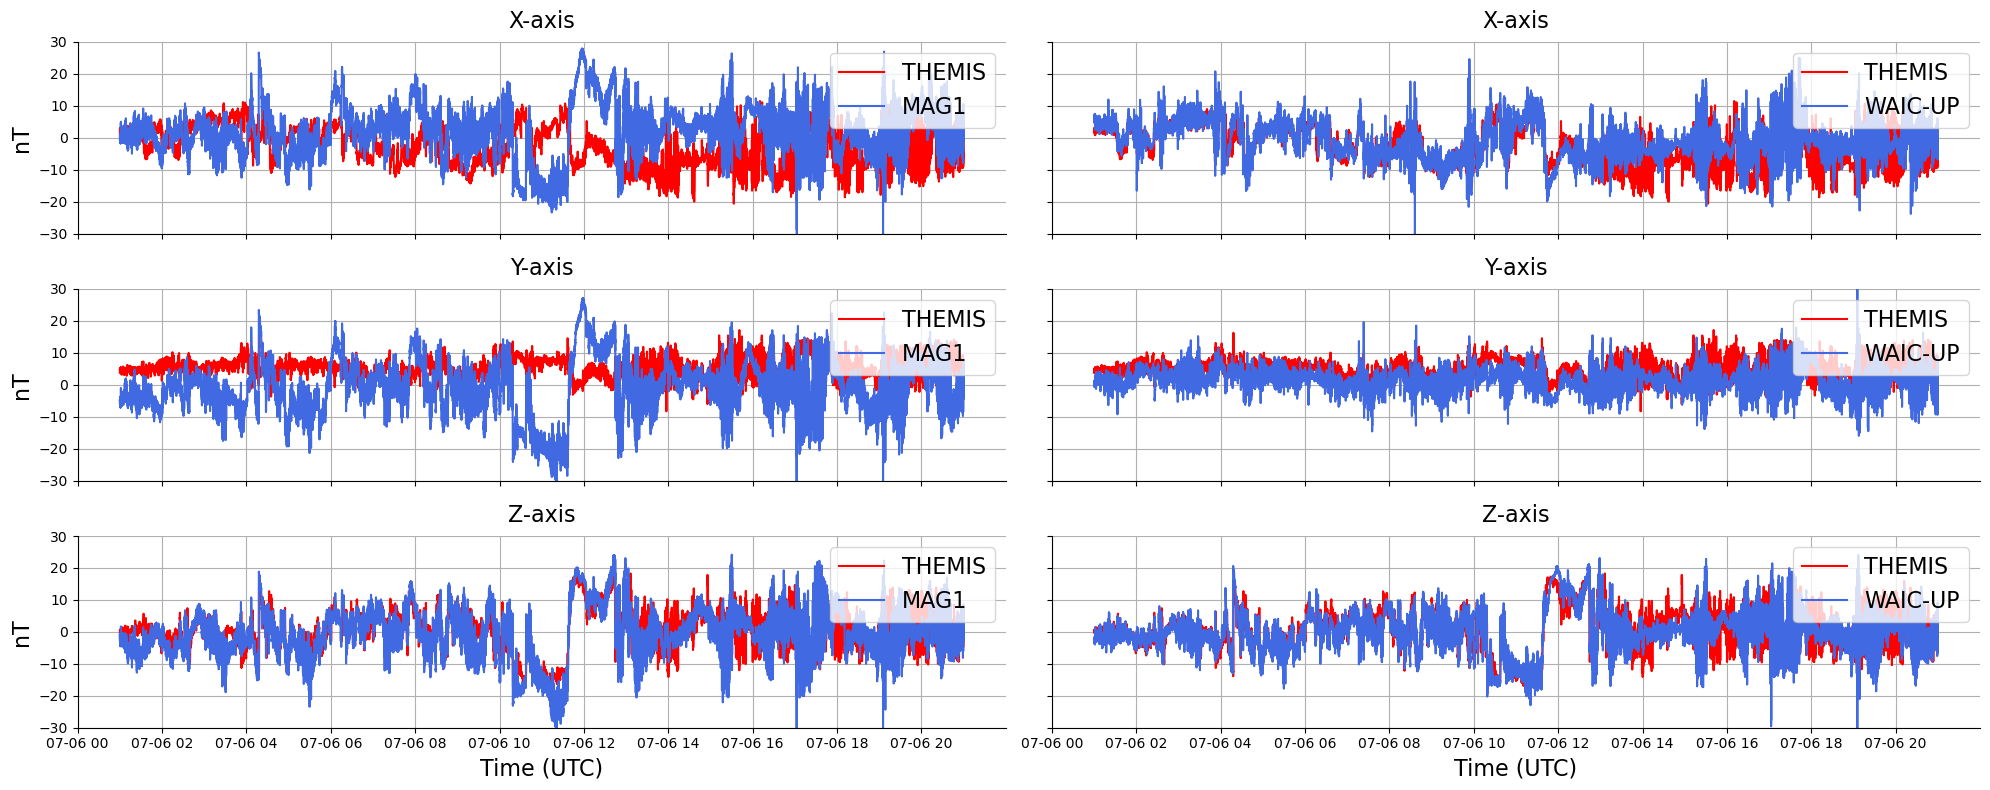

In [13]:
"""Plot Noise and Cleaned Data"""
fig, axs = plt.subplots(3, 2, figsize=(20, 8), sharex=True, sharey=True)

# Plotting
start = 25*3600; end = 45*3600; t_start = 20801; t_end = 37552


# Overplotting THEMIS data
axs[0,0].plot(themis_t[t_start:t_end], B_th[0,t_start:t_end], label="THEMIS", color='red')
axs[1,0].plot(themis_t[t_start:t_end], B_th[1,t_start:t_end], label="THEMIS", color='red')
axs[2,0].plot(themis_t[t_start:t_end], B_th[2,t_start:t_end], label="THEMIS", color='red')
axs[0,1].plot(themis_t[t_start:t_end], B_th[0,t_start:t_end], label="THEMIS", color='red')
axs[1,1].plot(themis_t[t_start:t_end], B_th[1,t_start:t_end], label="THEMIS", color='red')
axs[2,1].plot(themis_t[t_start:t_end], B_th[2,t_start:t_end], label="THEMIS", color='red')


axs[0,0].plot(kplo_t[start:end], B_kplo[0,2,start:end], label=f"MAG1", color='royalblue')
axs[1,0].plot(kplo_t[start:end], B_kplo[1,2,start:end], label=f"MAG1", color='royalblue')
axs[2,0].plot(kplo_t[start:end], B_kplo[2,2,start:end], label=f"MAG1", color='royalblue')
axs[0,1].plot(kplo_t[start:end], B_WAICUP[0,start:end], label=f"WAIC-UP", color='royalblue')
axs[1,1].plot(kplo_t[start:end], B_WAICUP[1,start:end], label=f"WAIC-UP", color='royalblue')
axs[2,1].plot(kplo_t[start:end], B_WAICUP[2,start:end], label=f"WAIC-UP", color='royalblue')

# set y-axis limits from -25 to 25 nT
for row in axs:
    for ax in row:
        ax.set_ylim(-30, 30)

# Adding Legends
axs[0,0].legend(loc=1, fontsize=16); axs[0,1].legend(loc=1, fontsize=16); axs[1,0].legend(loc=1, fontsize=16); axs[1,1].legend(loc=1, fontsize=16); axs[2,0].legend(loc=1, fontsize=16); axs[2,1].legend(loc=1, fontsize=16)


# Adding labels
axs[0,0].set_ylabel("nT", fontsize=16); axs[1,0].set_ylabel("nT", fontsize=16); axs[2,0].set_ylabel("nT", fontsize=16); 
axs[2,0].set_xlabel("Time (UTC)", fontsize=16); axs[2,1].set_xlabel("Time (UTC)", fontsize=16)

# Adding titles inside each subplot
axs[0,0].set_title("X-axis", loc='center', pad=10, fontsize=16); axs[0,1].set_title("X-axis", loc='center', pad=10, fontsize=16)
axs[1,0].set_title("Y-axis", loc='center', pad=10, fontsize=16); axs[1,1].set_title("Y-axis", loc='center', pad=10, fontsize=16)
axs[2,0].set_title("Z-axis", loc='center', pad=10, fontsize=16); axs[2,1].set_title("Z-axis", loc='center', pad=10, fontsize=16)

# Improving aesthetics
plt.tight_layout()
for row in axs:
    for ax in row:
        ax.grid(True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.show()

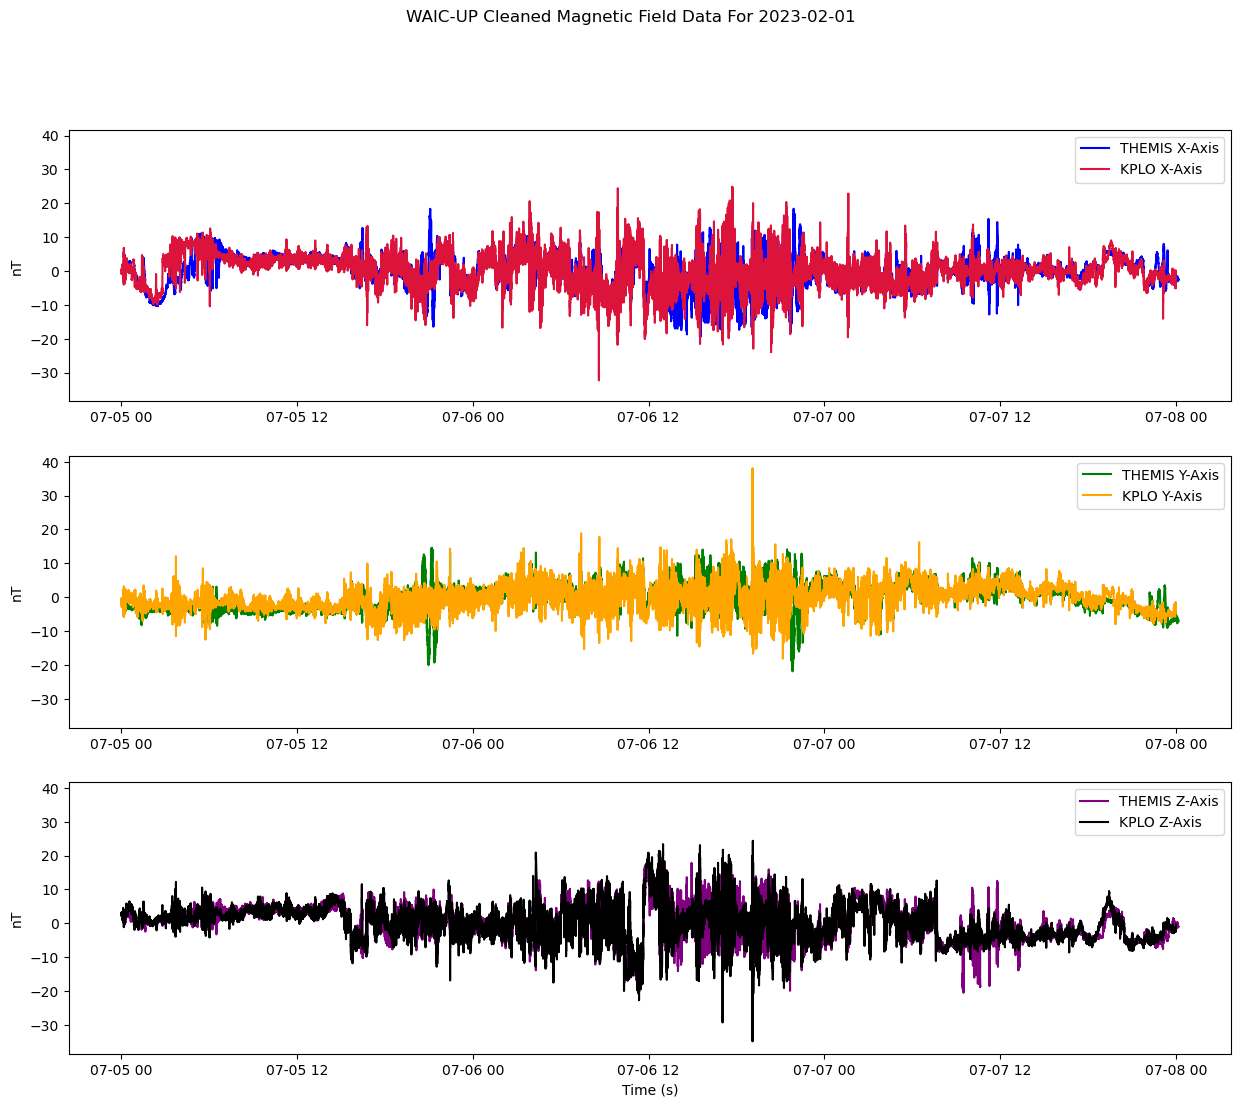

In [6]:
"Plot Data"
fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharey=True)
fig.suptitle("WAIC-UP Cleaned Magnetic Field Data For 2023-02-01")

for i in range(3):
    axs[i].plot(themis_t, B_th[i] - np.mean(B_th[i]), label=f"THEMIS {['X', 'Y', 'Z'][i]}-Axis", color = ['blue', 'green', 'purple'][i])
    axs[i].plot(kplo_t, B_WAICUP[i]- np.mean(B_WAICUP[i]), label=f"KPLO {['X', 'Y', 'Z'][i]}-Axis", color = ['crimson', 'orange', 'black'][i])

    axs[i].legend()
    axs[i].set_ylabel("nT")


axs[2].set_xlabel("Time (s)"); 
plt.legend()

In [15]:

from scipy import signal
B_th_resampled = np.array([signal.resample(B_th[i], B_WAICUP.shape[-1]) for i in range(3)])
themis_t_resampled = signal.resample(themis_t, B_WAICUP.shape[-1])


In [11]:
"Find Correlation of WAIC-UP"
from scipy.stats import pearsonr
B_noise = B_kplo[2]-B_kplo[0]

correlation = [pearsonr(B_noise[i], B_WAICUP[i])[0] for i in range(3)]
print(correlation)

correlation = [pearsonr(B_noise[i], B_kplo[0,i])[0] for i in range(3)]
print(correlation)

correlation = [pearsonr(B_th_resampled[i], B_kplo[0,i,:])[0] for i in range(3)]
print(correlation)

[-0.04440248308514942, -0.04448173613576913, -0.002882560670758119]
[-0.48914593087124997, -0.7849289174451184, -0.3062859055550912]
[0.3929851117129016, 0.26655591272431567, 0.48959631908612566]


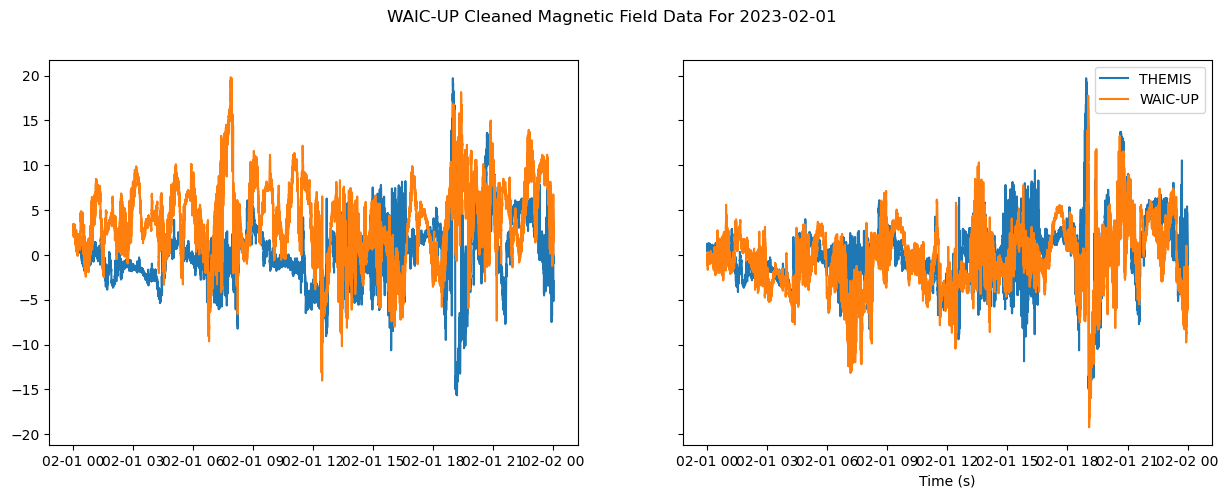

In [28]:
from scipy import signal
"Plot Data"
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle("WAIC-UP Cleaned Magnetic Field Data For 2023-02-01")

axs[0].plot(themis_t, B_th[2], label=f"THEMIS")
axs[0].plot(kplo_t, B_kplo[2,0], label=f"KPLO")

axs[1].plot(kplo_t, signal.resample(B_th[2],B_WAICUP.shape[-1]), label=f"THEMIS")
axs[1].plot(kplo_t, B_WAICUP[2], label=f"WAIC-UP")

axs[1].set_xlabel("Time (s)"); 
plt.legend()

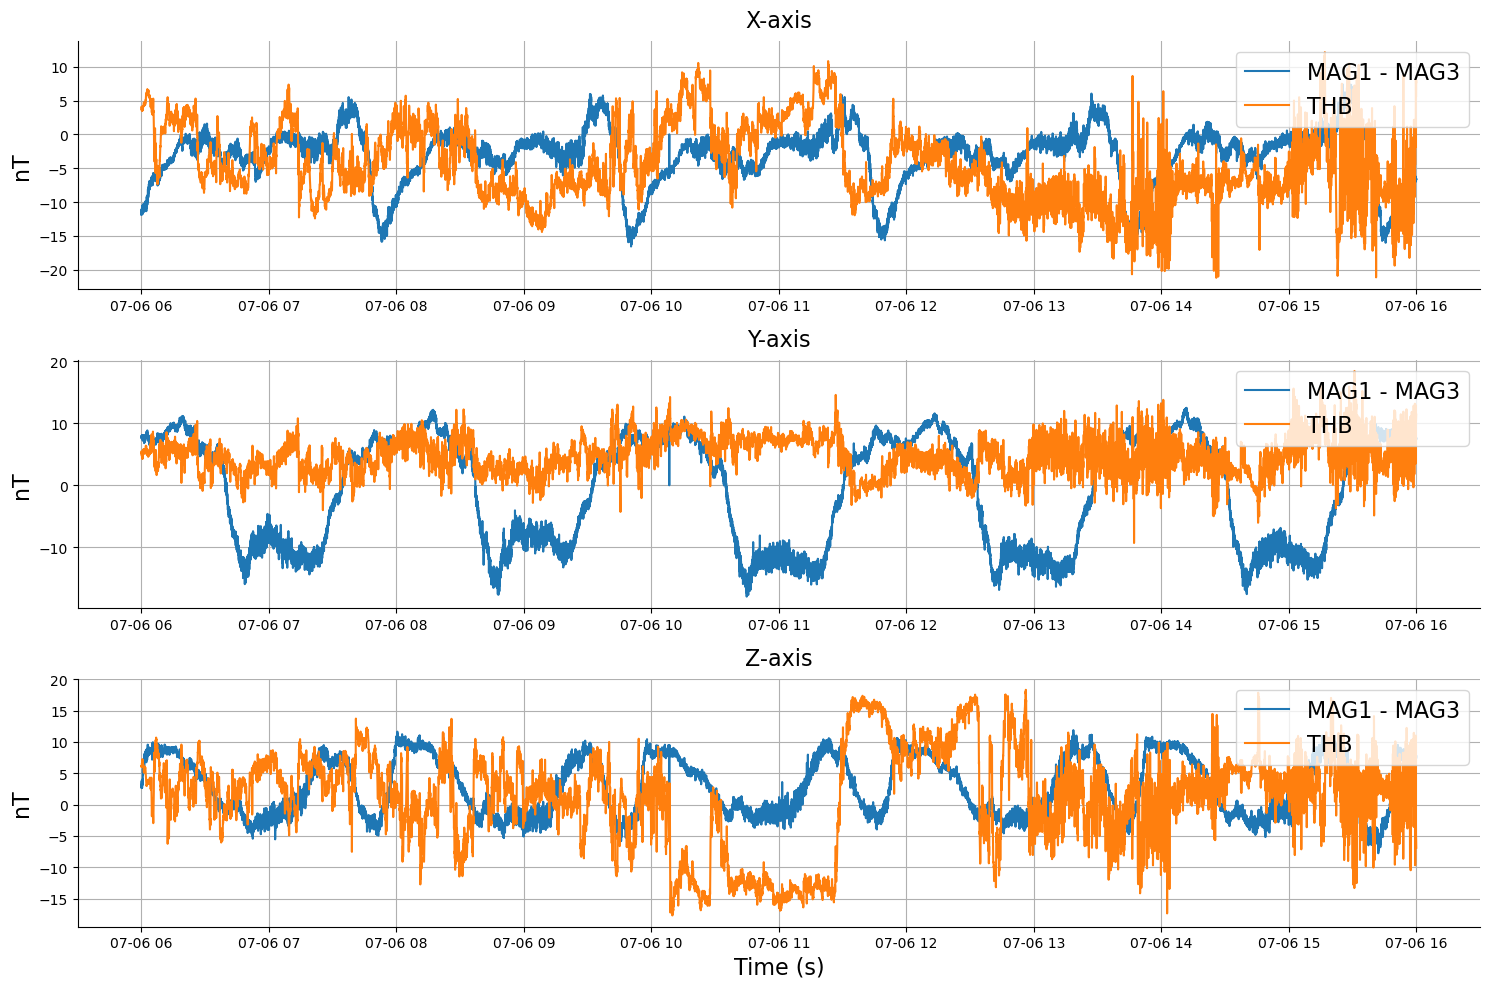

In [83]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
start = 30*3600; end = 40*3600

# Plotting
axs[0].plot(kplo_t[start:end], B_kplo[0,0,start:end]-B_kplo[2,0,start:end], label=f"MAG1 - MAG3")
axs[0].plot(kplo_t[start:end], B_th_resampled[0,start:end], label=f"THB")
axs[1].plot(kplo_t[start:end], B_kplo[0,1,start:end]-B_kplo[2,1,start:end], label=f"MAG1 - MAG3")
axs[1].plot(kplo_t[start:end], B_th_resampled[1,start:end], label=f"THB")
axs[2].plot(kplo_t[start:end], B_kplo[0,2,start:end]-B_kplo[2,2,start:end], label=f"MAG1 - MAG3")
axs[2].plot(kplo_t[start:end], B_th_resampled[2,start:end], label=f"THB")

# Adding legends
axs[0].legend(loc=1, fontsize=16)
axs[1].legend(loc=1, fontsize=16)
axs[2].legend(loc=1, fontsize=16)

# Adding titles inside each subplot
axs[0].set_title("X-axis", loc='center', pad=10, fontsize=16)
axs[1].set_title("Y-axis", loc='center', pad=10, fontsize=16)
axs[2].set_title("Z-axis", loc='center', pad=10, fontsize=16)

# Adding labels
for ax in axs:
    ax.set_ylabel("nT", fontsize=16)
axs[2].set_xlabel("Time (s)", fontsize=16)

# Improving aesthetics
plt.tight_layout()
for ax in axs:
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()

In [20]:
"Take Continuous Wavelet Transform"
fs_waicup_kplo = 4  # Hz
fs_th = 1  # Hz
f0 = 0.0001*4  # Hz
f1 = 0.25 / 2*4  # Hz

# Plot each signal
start =0# 25 * 3600
end = -1#45 * 3600
t_start = 0# 20801
t_end = -1#37552

# take transform of B_kplo Z-axis
freqs_kplo, out_kplo = fcwt.cwt(B_kplo[2,2,start:end], fs_waicup_kplo, f0, f1, fn=300, scaling='log', nthreads=12)
freqs_kplo = np.flip(freqs_kplo)

# take transform of WAICUP Z-axis
freqs_waicup, out_waicup = fcwt.cwt(B_WAICUP[2], fs_waicup_kplo, f0, f1, fn=300, scaling='log', nthreads=12)
freqs_waicup = np.flip(freqs_waicup)

# take transform of B_kplo Z-axis
freqs_th, out_th = fcwt.cwt(B_th[2], fs_th, f0, f1, fn=300, scaling='log', nthreads=12)
freqs_th = np.flip(freqs_th)

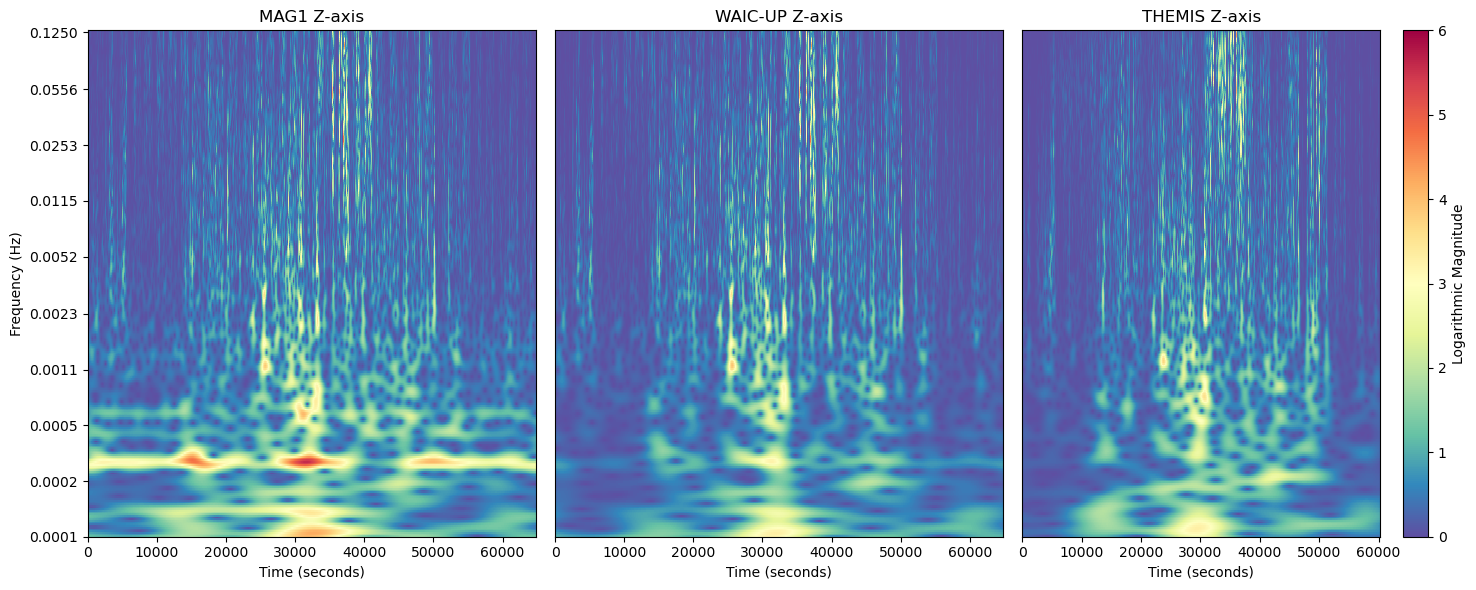

In [24]:

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
extent_kplo = [0, out_kplo.shape[1] / fs_waicup_kplo, 0, out_kplo.shape[0]]
extent_th = [0, out_th.shape[1] / fs_th, 0, out_th.shape[0]]
cax1 = axs[0].imshow(np.abs(out_kplo), aspect='auto', extent=extent_kplo, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0, vmax=6)
cax2 = axs[1].imshow(np.abs(out_waicup), aspect='auto', extent=extent_kplo, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0, vmax=6)
cax3 = axs[2].imshow(np.abs(out_th), aspect='auto', extent=extent_th, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0, vmax=6)

#fig.colorbar(cax1, ax=axs[0], label='Logarithmic Magnitude')
#fig.colorbar(cax2, ax=axs[1], label='Logarithmic Magnitude')
fig.colorbar(cax3, ax=axs[2], label='Logarithmic Magnitude')

yticks_kplo = np.linspace(0, len(freqs_kplo) - 1, 10).astype(int)
yticklabels_kplo = [f"{freqs_kplo[i]/4:.4f}" for i in yticks_kplo]

axs[0].set_yticks(yticks_kplo)
axs[0].set_yticklabels(yticklabels_kplo)
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_title("MAG1 Z-axis")

# TURN OFF YTICKS FOR AXS[1] AND AXS[2]
axs[1].set_yticks([])
axs[1].set_xlabel('Time (seconds)')
axs[1].set_title("WAIC-UP Z-axis")
axs[2].set_yticks([])
axs[2].set_xlabel('Time (seconds)')
axs[2].set_title("THEMIS Z-axis")


plt.tight_layout()
plt.show()
